In [1]:
import casadi as ca
import matplotlib.pyplot as plt
%matplotlib inline

$m \ddot{x} + c \dot{x} + k x + sin(x) = u$

$\vec{x} = \begin{bmatrix}
x \\
\dot{x}
\end{bmatrix}$

$\vec{u} = \begin{bmatrix} u\end{bmatrix}$

$\vec{y} = \vec{g}(\vec{x}) = \begin{bmatrix} x\end{bmatrix}$

$\ddot{x} = (-c \dot{x} - kx + u)/m$

$\dot{\vec{x}} = \vec{f}(\vec{x}) = \begin{bmatrix}
\dot{x} \\
(-c \dot{x} - kx - sin(x) + u)/m
\end{bmatrix}$

$\dot{\vec{x}} = A \vec{x} + B \vec{u}$

$\vec{y} = C \vec{x} + D \vec{u}$

$A = \dfrac{\partial \vec{f}}{\partial \vec{x}}$

$B = \dfrac{\partial \vec{f}}{\partial \vec{u}}$

$C = \dfrac{\partial \vec{g}}{\partial \vec{x}}$

$D = \dfrac{\partial \vec{g}}{\partial \vec{u}}$

In [2]:
m = ca.SX.sym('m')
c = ca.SX.sym('c')
k = ca.SX.sym('k')
p = ca.vertcat(m, c, k)

u = ca.SX.sym('u')
xv = ca.SX.sym('x', 2)
x = xv[0]
xd = xv[1]

y = x

xv_dot = ca.vertcat(xd, (-c*xd - k*x - ca.sin(x) + u + 3)/m)
xv_dot

SX([x_1, (((u-(((c*x_1)+(k*x_0))+sin(x_0)))+3)/m)])

In [3]:
f_rhs = ca.Function('rhs', [xv, u, p], [xv_dot], ['x', 'u', 'p'], ['x_dot'], {'jit': True})
f_rhs

Function(rhs:(x[2],u,p[3])->(x_dot[2]) SXFunction)

In [4]:
f_rhs([1, 2], [0], [1, 2, 3])

DM([2, -4.84147])

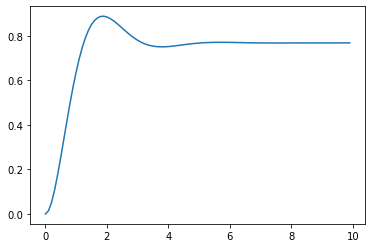

In [5]:
import scipy.integrate
import numpy as np
tf = 10
res = scipy.integrate.solve_ivp(
    fun=lambda t, x: np.array(f_rhs(x, 0.0, [1, 2, 3])).reshape(-1),
    t_span=[0, tf],
    y0=[0, 0], t_eval=np.arange(0, tf, 0.1))
plt.plot(res['t'], res['y'][0, :]);

In [6]:
A = ca.jacobian(xv_dot, xv)
A

SX(
[[00, 1], 
 [(-((k+cos(x_0))/m)), (-(c/m))]])

In [7]:
B = ca.jacobian(xv_dot, u)
B

SX([00, (1./m)])

In [8]:
C = ca.jacobian(y, xv)
C

SX([[1, 00]])

In [9]:
D = ca.jacobian(y, u)
D

SX(00)

In [10]:
f_ss = ca.Function('f_ss', [xv, p], [A, B, C, D], ['x', 'p'], ['A', 'B', 'C', 'D'])
f_ss

Function(f_ss:(x[2],p[3])->(A[2x2,3nz],B[2x1,1nz],C[1x2,1nz],D[1x1,0nz]) SXFunction)

In [11]:
import control
sys = control.ss(*f_ss([0, 0], [1, 2, 3]))
sys

A = [[ 0.  1.]
 [-4. -2.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]

In [12]:
f_rhs.generate('rhs.c')
#!cat rhs.c

'rhs.c'

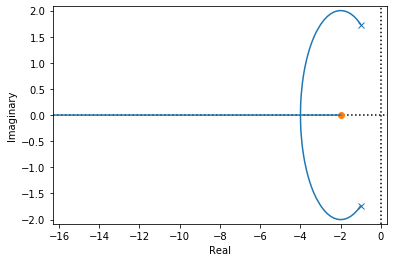

In [13]:
s = control.TransferFunction([1, 0], [0, 1])
H = (s + 2)
control.rlocus(H*sys);

In [14]:
H*sys


    s + 2
-------------
s^2 + 2 s + 4

# Linear Time Invariant Systems (LTI)

* Transfer Functions: $G(s) = s/(s+1)$
* State-space: $\dot{x} = Ax + Bu$, $y = Cx + Du$
* Impulse response function: $g(t)$

* $\dot{x} = a_1 x + a_2 x + b u$, $y = c x + du$ Linear?  (Yes) Because A = A1 + A2
* $\dot{x} = a_1 x + 3 + b u$, $y = c x + du$ Linear?  (No, not a linear system)

* What u would balance this equation at x=0?  -> u0 = -3/b (trim input)

For compensated dynamcis to be $G(s) = 1/(s+1)$,  u(x)=?

* LTI $\implies$ zero in -> zero out

$u(x) = (-a1 x - x - 3)/b$

$\dot{x} = -x$

# Trimming the MSD

In [15]:
f_rhs([0, 0], [-3], [1, 2, 3])

DM([0, 0])

$\dot{x} = Ax + Bu$, $y = Cx + Du + 3$   (non-linear -> violates zero in zero out law)

Trimming an aircraft means, finding where the rhs = 0,  or $f(t, x) = 0$, in order to do this we want to minimize
$dot(f(t, x), f(t, x))$.

In [16]:
def trim_function(xv_dot):
#    return xv_dot[0] + xv_dot[1] # BAD, will drive to -inf
    return xv_dot[0]**2 + xv_dot[1]**2

This design problems find the state at which a given input will drive the sytem to.

* x is the design vector
* f is the objective function
* p is a list of constant parameters
* S is the solver itself

In [17]:
nlp = {'x':xv, 'f':trim_function(xv_dot), 'p': ca.vertcat(p, u)}
S = ca.nlpsol('S', 'ipopt', nlp)
print(S)

S:(x0[2],p[4],lbx[2],ubx[2],lbg[0],ubg[0],lam_x0[2],lam_g0[0])->(x[2],f,g[0],lam_x[2],lam_g[0],lam_p[4]) IpoptInterface


In [18]:
S(x0=(0, 0), p=(1, 2, 3, 0))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

{'f': DM(1.51173e-30),
 'g': DM([]),
 'lam_g': DM([]),
 'lam_p': DM([1.57772e-30, 1.51029e-30, 1.36486e-15, -1.77636e-15]),
 'lam_x': DM([0, 0]),
 'x': DM([0.76835, 8.50215e-16])}

In [19]:
nlp = {'x':u, 'f':trim_function(xv_dot), 'p': ca.vertcat(p, xv)}
S2 = ca.nlpsol('S', 'ipopt', nlp)
print(S2)

S:(x0,p[5],lbx,ubx,lbg[0],ubg[0],lam_x0,lam_g0[0])->(x,f,g[0],lam_x,lam_g[0],lam_p[5]) IpoptInterface


In [20]:
#res = S(x0=(0), p=(1, 2, 3, 0, 0))
#print('we need a trim input of {:f}'.format(float(res['x'])))

In [21]:

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

S=2170.0; 
CBAR=17.5; 
MASS=5.0e3; 
IYY= 4.1e6;
TSTAT=6.0e4; 
DTDV = -38.0;
ZE = 2.0; 
CDCLS= 0.042;
CLA = 0.085; # per degree
CMA =-0.022; # per degree
CMDE =-.016; # per degree
CMQ =-16.0; # per radian
CMADOT= -6.0; # per radian
CLADOT= 0.0; # per radian
RTOD = 57.29578; 
GD=32.17;
#code 190
#4tran 725 standered atmospher model

In [22]:
import casadi as ca
THTL = ca.SX.sym('THTL')
ELEV = ca.SX.sym('ELEV')
XCG = ca.SX.sym('XCG')
LAND = ca.SX.sym('LAND')
PHI = ca.SX.sym('PHI')
u = ca.vertcat(THTL, ELEV, XCG, LAND, PHI)

VT = ca.SX.sym('VT')
ALPHA = ca.SX.sym('ALPHA')
THETA = ca.SX.sym('THETA')
Q = ca.SX.sym('Q')
H = ca.SX.sym('H')
PX = ca.SX.sym('PX')

In [23]:
RO = ca.SX(2.377e-3)
TFAC = ca.SX(1.0 - 0.703e-5 * H)
T = ca.SX(519*TFAC)
RHO = ca.SX(RO*(TFAC**4.14))#density
QBAR = ca.SX(0.5*RHO*VT*VT)#dynamic Pressure
CPS = ca.SX(1715.0*RHO*T)
#draw_graph(QBAR)

In [24]:
#no flaps

In [25]:
CLO = ca.SX(.20)
CDO = ca.SX(0.016)
CMO = ca.SX(0.05)
DCDG = ca.SX(0)
DCMG = ca.SX(0)

In [26]:
# Equations

In [27]:
QS = ca.SX(QBAR*S)
SALP = ca.sin(ALPHA+PHI)
CALP = ca.cos(ALPHA+PHI)
GAM = ca.SX(THETA-ALPHA)
SGAM = ca.sin(GAM)
CGAM = ca.cos(GAM)

THR = ca.SX((TSTAT+VT*DTDV) * ca.fmax(THTL,0))#Thrust
CL = ca.SX(CLO+CLA*ALPHA) #NONDIM. LIFT
CM = ca.SX(DCMG+CMO+CMA*ALPHA+CMDE*ELEV+CL* (XCG-.25)) #MOMENT
CD = ca.SX(DCDG+CDO+CDCLS*CL*CL) #DRAG POLAR

In [28]:
#EQU of motion

In [29]:
x1 = ((THR*CALP-QS*CD)/MASS - GD*SGAM)
x2 = ((-THR*SALP-QS*CL+MASS*(VT*Q+GD*CGAM))/(MASS*VT+QS*CLADOT))
x3 = (Q)
D = ((1/2)*CBAR*(CMQ*Q+CMADOT*x2/VT)) #PITCH DAMPING
x4 = ((QS*CBAR*(CM+D)+THR*ZE)/IYY) #Q-DOT
x5 = (VT*SGAM) #VERTICAL SPEED
x6 = (VT*CGAM) #ORIZNTal SPEED

In [35]:
totalbal=x1**2 + x2**2 + x4**2 + x5**2
trimm=ca.mmin(totalbal)
#draw_graph(trimm) 
x = ca.vertcat(x1, x2, x3, x4, x5, x6)

In [39]:
def objective(s, VT, H, GAMMA):
    THRTL = s[0]
    ELEV = s[1]
    ALPHA = s[2]
    PHI = s[3]
    
    POS = 0
    Q = 0
    XCG = 0.25
    THETA = ALPHA+GAMMA
    
    x = ca.vertcat(thtl, elev, xcg, land)
    
    x = ca.vertcat

In [ ]:
nlp = {'x': s, 'f': objectives(s, VT=500, H=0, GAMMA=0)}
S = 